<h1 align="center" style="color:#6699ff"> DataCamp IEEE Fraud Detection </h1>

<img src="https://github.com/DataCampM2DSSAF/suivi-du-data-camp-equipe-tchouacheu-niang-chokki/blob/master/img/credit-card-fraud-detection.png?raw=true" width="800" align="center">

#  <a style="color:#6699ff"> Team </a>
- <a style="color:#6699ff">Mohamed NIANG </a>
- <a style="color:#6699ff">Fernanda Tchouacheu </a>
- <a style="color:#6699ff">Hypolite Chokki </a>

# <a style="color:#6699ff">  Table of Contents</a> 

<a style="color:#6699ff"> I. Introduction</a>

<a style="color:#6699ff"> II. Descriptive Statistics & Visualization</a>

<a style="color:#6699ff"> III. Preprocessing</a>

<a style="color:#6699ff"> IV. Machine Learning Models</a>

# <a style="color:#6699ff"> I. Introduction</a>

**Pourquoi la détection de fraude ?**
> La fraude est un commerce d'un milliard de dollars et elle augmente chaque année. L'enquête mondiale de PwC sur la criminalité économique de 2018 a révélé que la moitié (49 %) des 7 200 entreprises interrogées avaient été victimes d'une fraude quelconque. C'est une augmentation par rapport à l'étude PwC de 2016, dans laquelle un peu plus d'un tiers des organisations interrogées (36 %) avaient été victimes de la criminalité économique.


Cette compétition est un problème de **classification binaire** - c'est-à-dire que notre variable cible est un attribut binaire (l'utilisateur qui fait le clic est-il frauduleux ou non ?) et notre objectif est de classer les utilisateurs en "frauduleux" ou "non frauduleux" le mieux possible.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file 

import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import os
os.chdir('/kaggle/input/ieeedatapreprocessing') # Set working directory
print(os.listdir('/kaggle/input/ieeedatapreprocessing'))

['sample_submission.csv', 'train_df.pkl', 'test_df.pkl']


**Load data**

In [2]:
%%time
X_train = pd.read_pickle('train_df.pkl')
X_test = pd.read_pickle('test_df.pkl')
print ("Data is loaded!")

Data is loaded!
CPU times: user 679 ms, sys: 2.89 s, total: 3.57 s
Wall time: 3.94 s


In [3]:
print('train_transaction shape is {}'.format(X_train.shape))
print('test_transaction shape is {}'.format(X_test.shape))

train_transaction shape is (590540, 226)
test_transaction shape is (506691, 226)


In [4]:
X_train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,EMAILP
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,4,13926,-999.0,150.0,2,142.0,2,...,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0
2987001,0,86401,29.0,4,2755,404.0,150.0,3,102.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2987003,0,86499,50.0,4,18132,567.0,150.0,3,117.0,3,...,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,9
2987004,0,86506,50.0,1,4497,514.0,150.0,3,102.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [5]:
X_test.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,EMAILP
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,0,18403224,31.95,4,10409,111.0,150.0,4,226.0,3,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5
3663550,0,18403263,49.00,4,4272,111.0,150.0,4,226.0,3,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
3663551,0,18403310,171.00,4,4476,574.0,150.0,4,226.0,3,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,6
3663552,0,18403310,284.95,4,10989,360.0,150.0,4,166.0,3,...,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,5
3663553,0,18403317,67.95,4,18018,452.0,150.0,3,117.0,3,...,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,5


# <a style="color:#6699ff"> IV. Machine Learning Models</a>

## XGBoost feature engineering

In [6]:
# NORMALIZE D COLUMNS
for i in [1,2,3,4,5,10,11,15]:
    if i in [1,2,3,5]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [7]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# LABEL ENCODE 2
def encode_LE2(df1,df2,col,verbose=True):
    df_comb = pd.concat([df1[col],df2[col]],axis=0)
    df_comb,_ = df_comb.factorize()
    df1[col] = df_comb[:len(df1)].astype('int32')
    df2[col] = df_comb[len(df1):].astype('int32')
    if verbose: print(col,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [8]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')

In [9]:
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D10','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D10_card1_mean' , 'D10_card1_std' , 'D10_card1_addr1_mean' , 'D10_card1_addr1_std' , 'D10_card1_addr1_P_emaildomain_mean' , 'D10_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

In [10]:
# ADD MONTH FEATURE
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [11]:
# ADD UID FEATURE
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)
# LABEL ENCODE
encode_LE2(X_train,X_test,'uid',verbose=False)

In [12]:
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

In [13]:
idxT = X_train.index[:4*len(X_train)//5]
idxV = X_train.index[4*len(X_train)//5:]

In [14]:
cols_to_drop = ["TransactionID", "isFraud", "TransactionDT"]
useful_cols = list(X_train.columns)

for col in cols_to_drop:
    while True:
        try:
            useful_cols.remove(col)
        except:
            break

In [15]:
print('NOW USING THE FOLLOWING',len(useful_cols),'FEATURES.')
np.array(useful_cols)

NOW USING THE FOLLOWING 255 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'C1',
       'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74',
       'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
       

## XGBoost classifier with cross validation

In [16]:
y_train = X_train['isFraud'].copy()

In [17]:
skf = GroupKFold(n_splits=6)

for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    
    xgboost_magic_classifier = xgb.XGBClassifier(
            n_estimators=15000,
            max_depth=20,
            learning_rate=0.02,
            subsample=0.8,
            eval_metric='auc',
            colsample_bytree=0.4,
            missing=-999,
            tree_method='gpu_hist' 
        )   
    
    xgboost_magic_classifier_fit = xgboost_magic_classifier.fit(X_train[useful_cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[useful_cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=500)
    
    oof[idxV] += xgboost_magic_classifier.predict_proba(X_train[useful_cols].iloc[idxV])[:,1]
    preds += xgboost_magic_classifier.predict_proba(X_test[useful_cols])[:,1]/skf.n_splits
    
    del xgboost_magic_classifier_fit
    x = gc.collect()

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.73338
Will train until validation_0-auc hasn't improved in 500 rounds.
[100]	validation_0-auc:0.87328
[200]	validation_0-auc:0.88350
[300]	validation_0-auc:0.88615
[400]	validation_0-auc:0.88703
[500]	validation_0-auc:0.89015
[600]	validation_0-auc:0.89189
[700]	validation_0-auc:0.89355
[800]	validation_0-auc:0.89512
[900]	validation_0-auc:0.89656
[1000]	validation_0-auc:0.89756
[1100]	validation_0-auc:0.89868
[1200]	validation_0-auc:0.89910
[1300]	validation_0-auc:0.89966
[1400]	validation_0-auc:0.90013
[1500]	validation_0-auc:0.90045
[1600]	validation_0-auc:0.90087
[1700]	validation_0-auc:0.90112
[1800]	validation_0-auc:0.90138
[1900]	validation_0-auc:0.90184
[2000]	validation_0-auc:0.90214
[2100]	validation_0-auc:0.90264
[2200]	validation_0-auc:0.90293
[2300]	validation_0-auc:0.90309
[2400]	validation_0-auc:0.90300
[2500]	validation_0-auc:0.90331
[2600]	validation_0-auc:0.90332
[2700]

In [18]:
print(confusion_matrix(y_train, oof.round()))

[[568778   1099]
 [ 11797   8866]]


In [19]:
print(classification_report(y_train, oof.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    569877
           1       0.89      0.43      0.58     20663

    accuracy                           0.98    590540
   macro avg       0.93      0.71      0.78    590540
weighted avg       0.98      0.98      0.97    590540



**Feature importance for XGBoost with cross validation**

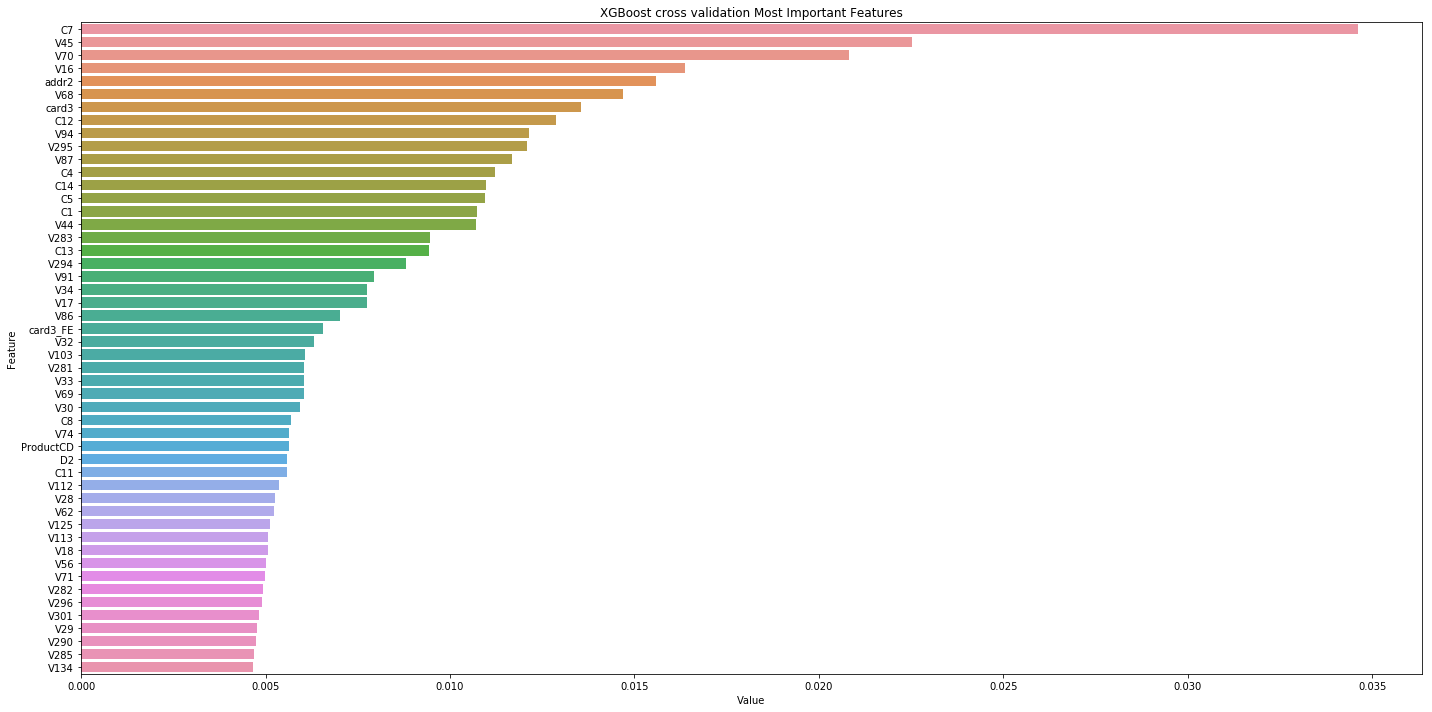

In [20]:
feature_imp = pd.DataFrame(sorted(zip(xgboost_magic_classifier.feature_importances_,useful_cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGBoost cross validation Most Important Features')
plt.tight_layout()
plt.show()

**Seventh submission for XGBOOST with cross validation**

In [21]:
submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')
submission.isFraud = preds
submission.head()

,isFraud
TransactionID,
3663549,0.000065
3663550,0.000206
3663551,0.000315
3663552,0.000182
3663553,0.000197


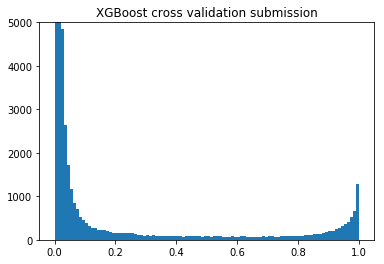

In [22]:
plt.hist(submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('XGBoost cross validation submission')
plt.show()

In [23]:
submission.to_csv('/kaggle/working/xgboost_cv_submission.csv')